In [1]:
import sys
sys.path.append("/Users/guoyaol/tvm/python/")
print(sys.path)

# import os

# # Replace this with the path to the 'nvcc' executable on your system
# nvcc_path = "/usr/local/cuda-11.8/bin"

# if nvcc_path not in os.environ["PATH"]:
#     os.environ["PATH"] += f":{nvcc_path}"

['/Users/guoyaoli/tvm_work/web-real-esrgan', '/Users/guoyaoli/tvm_work/tvm/python', '/Users/guoyaoli/tvm_work/web-real-esrgan', '/Users/guoyaoli/ENTER/envs/esr/lib/python38.zip', '/Users/guoyaoli/ENTER/envs/esr/lib/python3.8', '/Users/guoyaoli/ENTER/envs/esr/lib/python3.8/lib-dynload', '', '/Users/guoyaoli/ENTER/envs/esr/lib/python3.8/site-packages', '/Users/guoyaol/tvm/python/']


In [2]:
import numpy as np
import cv2
import os
import torch
import math
from torch.nn import functional as F
from network import RRDBNet
import tvm
from tvm import relax
from tvm.script import relax as R
from tvm.relax.frontend.torch import dynamo_capture_subgraphs
import torch
from typing import Dict, List, Tuple
import time

In [3]:
netscale = 4
model_path = "./weights/RealESRGAN_x4plus.pth"
model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4)
outscale = 4

In [4]:
def rrdb_net(model) -> tvm.IRModule:

    class RRDBNetWrapper(torch.nn.Module):
        def __init__(self, rrdb):
            super().__init__()
            self.rrdb = rrdb

        def forward(self, input):
            output = self.rrdb(input)
            return output

    rrdb = RRDBNetWrapper(model)

    #todo: change size
    z = torch.rand((1, 3, 160, 160), dtype=torch.float32)

    mod = dynamo_capture_subgraphs(
        rrdb.forward,
        z,
        keep_params_as_input=True,
    )
    assert len(mod.functions) == 1

    return tvm.IRModule({"rrdb": mod["subgraph_0"]})


In [5]:
def scale_image() -> tvm.IRModule:
    from tvm import te
    #divide each element by 255
    #todo: different sizes of images
    def f_scale_image(A):
        def fcompute(x, y, c):
            return A[x, y, c] / te.const(255, "float32")

        return te.compute((160, 160, 3), fcompute, name="scale_image")

    bb = relax.BlockBuilder()
    x = relax.Var("x", R.Tensor([160, 160, 3], "float32"))
    with bb.function("scale_image", [x]):
        image = bb.emit(
            bb.call_te(f_scale_image, x, primfunc_name_hint="tir_scale_image")
        )
        bb.emit_func_output(image)
    return bb.get()

In [6]:

def preprocess() -> tvm.IRModule:
    from tvm import te
    #np.transpose(img, (2, 0, 1)) and unqueeze(0)
    #todo: different sizes of images
    def f_preprocess(A):
        def fcompute(i, c, x, y):
            return A[x, y, c]
        return te.compute((1, 3, 160, 160), fcompute, name="preprocess")


    bb = relax.BlockBuilder()
    x = relax.Var("x", R.Tensor([160, 160, 3], "float32"))
    with bb.function("preprocess", [x]):
        image = bb.emit(
            bb.call_te(f_preprocess, x, primfunc_name_hint="tir_preprocess")
        )
        bb.emit_func_output(image)
    return bb.get()

In [7]:
def postprocess() -> tvm.IRModule:
    from tvm import te
    # output_img = output_img.data.squeeze().float().cpu().clamp_(0, 1).numpy()
    # output_img = np.transpose(output_img[[2, 1, 0], :, :], (1, 2, 0))
    def f_squeeze(A):
        def fcompute(c, x, y):
            return A[0, c, x, y]
        return te.compute((3, 640, 640), fcompute, name="squeeze")

    def f_swapchannel(A):
        def fcompute(c, x, y):
            return A[2-c, x, y]
        return te.compute((3, 640, 640), fcompute, name="swapnnel")
    
    def f_transpose(A):
        def fcompute(x, y, c):
            return A[c, x, y]
        return te.compute((640, 640, 3), fcompute, name="transpose")
    
    def f_max_0(A):
        def fcompute(c, x, y):
            return te.if_then_else(A[c, x, y] > te.const(0, "float32"), A[c, x, y], te.const(0, "float32"))
        return te.compute((3, 640, 640), fcompute, name="max0")
    
    def f_min_1(A):
        def fcompute(c, x, y):
            return te.if_then_else(A[c, x, y] < te.const(1, "float32"), A[c, x, y], te.const(1, "float32"))
        return te.compute((3, 640, 640), fcompute, name="min1")


    bb = relax.BlockBuilder()
    x = relax.Var("x", R.Tensor([1, 3, 640, 640], "float32"))
    with bb.function("postprocess", [x]):
        #squeeze
        squeezed = bb.emit(bb.call_te(f_squeeze, x, primfunc_name_hint="tir_squeeze"))
        #clamp
        maxed = bb.emit(bb.call_te(f_max_0, squeezed, primfunc_name_hint="tir_max_0"))
        clamped = bb.emit(bb.call_te(f_min_1, maxed, primfunc_name_hint="tir_min_1"))
        #rgb swap
        swapped = bb.emit(bb.call_te(f_swapchannel, clamped, primfunc_name_hint="tir_swapchannel"))
        #transpose
        out_image = bb.emit(bb.call_te(f_transpose, swapped, primfunc_name_hint="tir_transpose"))

        bb.emit_func_output(out_image)
    return bb.get()

In [8]:
def unscale_image() -> tvm.IRModule:
    from tvm import te
    #divide each element by 255
    #todo: different sizes of images
    def f_unscale_image(A):
        def fcompute(y, x, c):
            return te.round(A[y, x, c] * 255).astype("uint32")

        return te.compute((640, 640, 3), fcompute, name="unscale_image")

    bb = relax.BlockBuilder()
    x = relax.Var("x", R.Tensor([640, 640, 3], "float32"))
    with bb.function("unscale_image", [x]):
        image = bb.emit(
            bb.call_te(f_unscale_image, x, primfunc_name_hint="tir_unscale_image")
        )
        bb.emit_func_output(image)
    return bb.get()

In [9]:
def image_to_rgba() -> tvm.IRModule:
    from tvm import te

    def f_image_to_rgba(A):
        def fcompute(y, x):
            return (
                A[y, x, 2].astype("uint32")
                | (A[y, x, 1].astype("uint32") << 8)
                | (A[y, x, 0].astype("uint32") << 16)
                | tvm.tir.const(255 << 24, "uint32")
            )

        return te.compute((640, 640), fcompute, name="image_to_rgba")

    bb = relax.BlockBuilder()
    x = relax.Var("x", R.Tensor([640, 640, 3], "uint32"))
    with bb.function("image_to_rgba", [x]):
        image = bb.emit(
            bb.call_te(f_image_to_rgba, x, primfunc_name_hint="tir_image_to_rgba")
        )
        bb.emit_func_output(image)
    return bb.get()

# Put Module together

In [10]:
#1. scale image
scale = scale_image()

#2. preprocess image
pre_pro = preprocess()

# 3. model inference
loadnet = torch.load(model_path, map_location=torch.device('cpu'))
model.load_state_dict(loadnet['params_ema'], strict=True)
rrdb = rrdb_net(model)

#4. post process
post_pro = postprocess()

#5. un-scale image
unscale = unscale_image()

image_to_rgba = image_to_rgba()

#---------------------merge together---------------------
def merge_irmodules(*irmodules: tvm.IRModule) -> tvm.IRModule:
    merged_mod = tvm.IRModule()

    for mod in irmodules:
        for gv, func in mod.functions.items():
            merged_mod[gv] = func
    return merged_mod

mod: tvm.IRModule = merge_irmodules(
    scale,
    pre_pro,
    rrdb,
    post_pro,
    unscale,
    image_to_rgba
)

seperate model and params

In [11]:
mod, params = relax.frontend.detach_params(mod)

# Optimization

In [12]:
mod = relax.pipeline.get_pipeline()(mod)

entry_funcs = ["scale_image", "preprocess", "rrdb", "postprocess", "unscale_image", "image_to_rgba"]
mod = relax.transform.DeadCodeElimination(entry_funcs)(mod)

mod = relax.transform.LiftTransformParams()(mod)

for global_var, function in mod.functions.items():
    if isinstance(function, relax.Function):
        if global_var.name_hint.endswith("_transform_params"):
            print(
                global_var.name_hint,
                f' # <=== This is the weight parameter computation function for "{global_var.name_hint[:-17]}"',
            )
        else:
            print(global_var.name_hint)

unscale_image
preprocess
rrdb
postprocess
rrdb_transform_params  # <=== This is the weight parameter computation function for "rrdb"
scale_image
image_to_rgba


# split build and deployment

In [13]:
def print_relax_funcnames(mod: tvm.IRModule):
    for global_var, func in mod.functions.items():
        if isinstance(func, relax.Function):
            print(global_var.name_hint)
    print()

def split_transform_deploy_mod(
    mod: tvm.IRModule, model_names: List[str], mod_deploy_entry_func: List[str]
) -> Tuple[tvm.IRModule, tvm.IRModule]:
    mod_transform = tvm.IRModule()
    mod_deploy = tvm.IRModule()

    transform_func_names = [name + "_transform_params" for name in model_names]
    for gv in mod.functions:
        func = mod[gv]
        if isinstance(func, tvm.tir.PrimFunc):
            mod_transform[gv] = func
            mod_deploy[gv] = func
        elif gv.name_hint in transform_func_names:
            mod_transform[gv] = func
        else:
            mod_deploy[gv] = func

    mod_transform = relax.transform.DeadCodeElimination(transform_func_names)(
        mod_transform
    )
    mod_deploy = relax.transform.DeadCodeElimination(mod_deploy_entry_func)(
        mod_deploy
    )

    return mod_transform, mod_deploy

model_names = ["rrdb"]

mod_transform, mod_deploy = split_transform_deploy_mod(
    mod, model_names, entry_funcs
)

print("In IRModule for build stage:")
print_relax_funcnames(mod_transform)

print("In IRModule for deployment stage:")
print_relax_funcnames(mod_deploy)

In IRModule for build stage:
rrdb_transform_params

In IRModule for deployment stage:
preprocess
unscale_image
rrdb
postprocess
scale_image
image_to_rgba



# Prepare for build

In [14]:
def transform_params(
    mod_transform: tvm.IRModule, model_params: Dict[str, List[tvm.nd.NDArray]]
) -> Dict[str, List[tvm.nd.NDArray]]:
    ex = relax.build(mod_transform, target="llvm")
    vm = relax.vm.VirtualMachine(ex, tvm.cpu())
    new_params = dict()
    for name, params in model_params.items():
        new_params[name] = vm[name + "_transform_params"](params)
    return new_params


def save_params(params: Dict[str, List[tvm.nd.NDArray]], artifact_path: str) -> None:
    from tvm.contrib import tvmjs

    meta_data = {}
    param_dict = {}
    for model in ["rrdb"]:
        total_size = 0.0
        
        meta_data[f"{model}ParamSize"] = len(params[model])
        for i, nd in enumerate(params[model]):
            param_dict[f"{model}_{i}"] = nd

            np_nd = nd.numpy()
            total_size += np_nd.size * np_nd.dtype.itemsize
        total_size = total_size / 1024.0 / 1024.0 / 1024.0
        print(f"Total param size: {total_size} GB")

    tvmjs.dump_ndarray_cache(param_dict, f"{artifact_path}/params", meta_data=meta_data)

new_params = transform_params(mod_transform, params)
save_params(new_params, artifact_path="dist")

Memory usage estimation:
- Function rrdb_transform_params:
 * Without memory planning, there are 0 constant-size memory allocation(s) with total size 0.0 GB.
 * With memory planning, there are 0 constant-size memory allocation(s) with total size 0.0 GB.

Total param size: 0.06220484897494316 GB
Start storing to cache dist/params
[0702/0702] saving rrdb_701
All finished, 1 total shards committed, record saved to dist/params/ndarray-cache.json
Also saved a bf16 record to dist/params/ndarray-cache-b16.json


# Build

In [15]:
target = tvm.target.Target("apple/m2-gpu")
device = tvm.metal()

In [16]:
from tvm import meta_schedule as ms

db = ms.database.create(work_dir="log_db_tuning_1000_small")
with target, db, tvm.transform.PassContext(opt_level=3):
    # mod_deploy = relax.transform.MetaScheduleApplyDatabase()(mod_deploy)
    mod_deploy = tvm.tir.transform.DefaultGPUSchedule()(mod_deploy)

In [17]:
ex = relax.build(mod=mod_deploy, target=target)

Memory usage estimation:
- Function unscale_image:
 * Without memory planning, there are 1 constant-size memory allocation(s) with total size 0.004578 GB.
 * With memory planning, there are 0 constant-size memory allocation(s) with total size 0.0 GB.
 * Memory planning reduces constant memory size to 0.0%.- Function preprocess:
 * Without memory planning, there are 1 constant-size memory allocation(s) with total size 0.0002861 GB.
 * With memory planning, there are 0 constant-size memory allocation(s) with total size 0.0 GB.
 * Memory planning reduces constant memory size to 0.0%.- Function rrdb:
 * Without memory planning, there are 629 constant-size memory allocation(s) with total size 5.412 GB.
 * With memory planning, there are 8 constant-size memory allocation(s) with total size 0.2228 GB.
 * Memory planning reduces constant memory size to 4.1%.- Function postprocess:
 * Without memory planning, there are 5 constant-size memory allocation(s) with total size 0.02289 GB.
 * With mem

[13:47:22] /Users/guoyaoli/tvm_work/tvm/src/runtime/metal/metal_device_api.mm:165: Intializing Metal device 0, name=Apple M2 Max


In [18]:
ex.export_library("dist/real_esrgan.so")

# Local Deployment

load the model

In [19]:
target = tvm.target.Target("apple/m2-gpu")
device = tvm.metal()

In [20]:
def load_params(artifact_path: str, device) -> Dict[str, List[tvm.nd.NDArray]]:
    from tvm.contrib import tvmjs

    pdict = {}
    params, meta = tvmjs.load_ndarray_cache(f"{artifact_path}/params", device)
    for model in ["rrdb"]:
        plist = []
        size = meta[f"{model}ParamSize"]
        for i in range(size):
            plist.append(params[f"{model}_{i}"])
        pdict[model] = plist
    return pdict

const_params_dict = load_params(artifact_path="dist", device=device)
ex = tvm.runtime.load_module("dist/real_esrgan.so")

In [21]:
vm = relax.VirtualMachine(rt_mod=ex, device=device)

# Define the Real-ESRGAN pipeline

In [22]:
from PIL import Image
class TVMESRPipeline:
    def __init__(
        self,
        vm: relax.VirtualMachine,
        tvm_device,
        param_dict,
    ):
        def wrapper(f, params):
            def wrapped_f(*args):
                return f(*args, params)

            return wrapped_f

        self.vm = vm
        
        self.rrdb = wrapper(vm["rrdb"], param_dict["rrdb"])
        
        self.scale_image = vm["scale_image"]
        self.preprocess = vm["preprocess"]
        self.unscale_image = vm["unscale_image"]
        self.postprocess = vm["postprocess"]
        self.image_to_rgba = vm["image_to_rgba"]

        self.tvm_device = tvm_device
        self.param_dict = param_dict

    def __call__(self, input_image: np.array):
        image = tvm.nd.array(input_image, device=self.tvm_device)
        image = self.scale_image(image)
        image = self.preprocess(image)
        image = self.rrdb(image)
        image = self.postprocess(image)
        image = self.unscale_image(image)
        image = self.image_to_rgba(image)
        return Image.fromarray(image.numpy().view("uint8").reshape(640, 640, 4))

# Run

In [23]:
pipe = TVMESRPipeline(vm, device, const_params_dict)

Our input image

In [24]:
input_path = "./input/160.jpg"
output_path = "./output"

imgname, extension = os.path.splitext(os.path.basename(input_path))
img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = img.astype(np.float32)

through the pipeline

In [25]:
output = pipe(img)

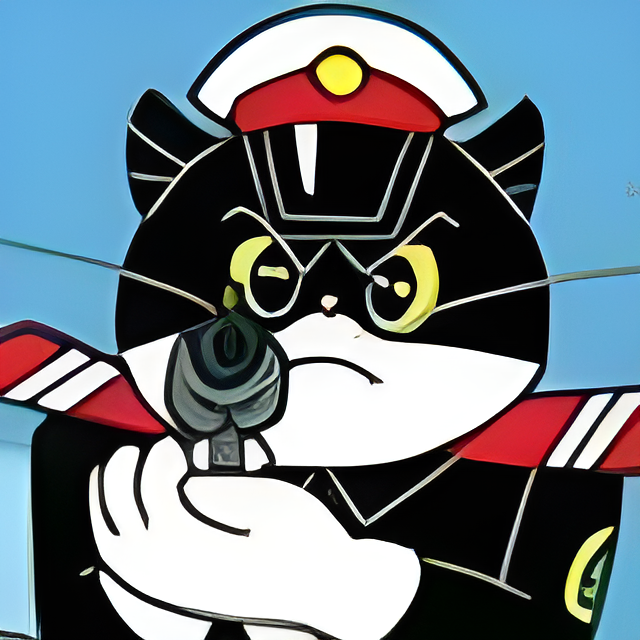

In [26]:
display(output)

In [27]:
final_result = output.numpy().astype(np.uint8)
cv2.imwrite("./output/TVM_output.png", final_result)

AttributeError: numpy